In [1]:
%load_ext autoreload
%autoreload 3

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from bamboo.conventions import Conventions
from bamboo.cross_validation import TimeSeriesCrossValidation
from bamboo.data_manager import DataManager
from bamboo.transformers import TransformerDropColumn
from bamboo.submission import create_submission

sns.set(context="paper", palette="colorblind")


In [3]:
SCORING = "neg_mean_absolute_error"

In [4]:
data_manager = DataManager()

In [18]:
def remove_nonfeature_columns(data):

    data = data.copy()
    cols = [
        Conventions.CITY,
        Conventions.YEAR,
        Conventions.WEEK_START_DATE,
    ]
    features = data.drop(columns=cols)
    if Conventions.TARGET in features.columns:
        target = features.pop(Conventions.TARGET)
    else:
        target = None

    return features, target


In [6]:
# Highly correlated
COLS_TO_REMOVE = [
    "precipitation_amt_mm",
    "reanalysis_air_temp_k",
    "reanalysis_dew_point_temp_k",
]

pipeline_features = make_pipeline(
    TransformerDropColumn(columns=COLS_TO_REMOVE),
    SimpleImputer(),
    MinMaxScaler(),
    RandomForestRegressor()
)

In [29]:
def plot_comparison(ax, prediction, target=None):

    prediction.plot(ax=ax, label="prediction")

    if target:
        error = mean_absolute_error(y_true=target, y_pred=prediction)
        target.plot(ax=ax, label="target", ls="--")
    else:
        error = np.inf
    
    ax.legend()
    ax.set(title=f"MAE : {error:.2f}", ylabel="Total num. dengue cases")


Test with out-of-the-box parameters

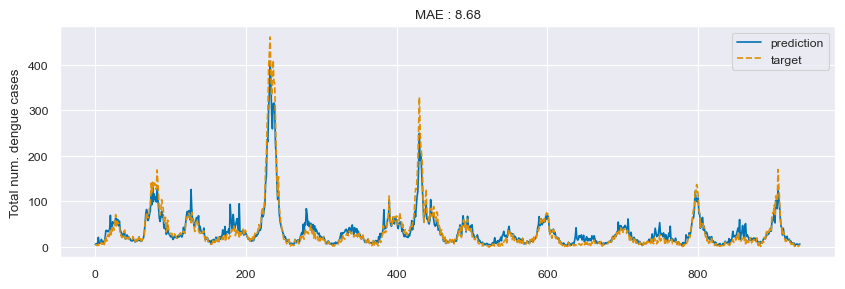

In [8]:
data= data_manager.get_city_training_data(city="sj")
features, target = remove_nonfeature_columns(data)

model = pipeline_features.fit(X=features, y=target)
prediction = model.predict(features)
prediction = pd.Series(data = prediction)
fig, ax = plt.subplots(figsize=(10, 3))
plot_comparison(ax=ax, prediction=prediction, target=target)

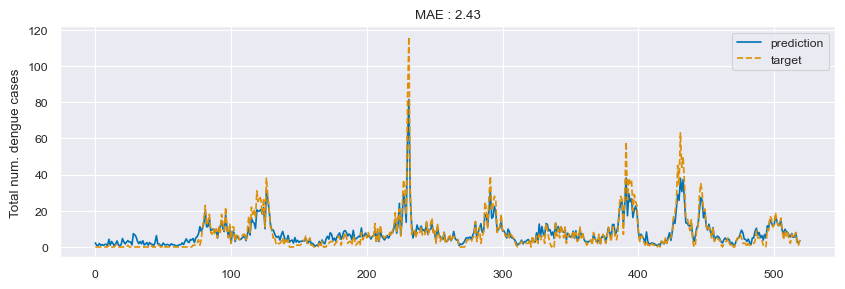

In [9]:
data= data_manager.get_city_training_data(city="iq")
features, target = remove_nonfeature_columns(data)

model = pipeline_features.fit(X=features, y=target)
prediction = model.predict(features)
prediction = pd.Series(data = prediction)
fig, ax = plt.subplots(figsize=(10, 3))
plot_comparison(ax=ax, prediction=prediction, target=target)

In [10]:
def train_model(city):

    data = data_manager.get_city_training_data(city)
    features, target = remove_nonfeature_columns(data)

    cv = TimeSeriesCrossValidation(
        n_splits=3,
        size_train=0.7,
        size_test=0.2,
        rnd_state=42,
    )
    space = {
        "randomforestregressor__max_depth": [2, 5, 10, 20],
        "randomforestregressor__min_samples_split": [2, 10, 20],
        "randomforestregressor__min_samples_leaf": [1, 5, 10],
        "randomforestregressor__max_features": [0.2, 1.0, "sqrt", "log2"],
    }
    clf = GridSearchCV(
        estimator=pipeline_features,
        param_grid=space,
        scoring=SCORING,
        cv=cv,
        pre_dispatch=8,
        verbose=1,
    )
    clf.fit(features, target)

    print(f"Best score : {-clf.best_score_:.2f}")

    # Evaluate over the whole time series
    prediction = pd.Series(
        data=clf.best_estimator_.predict(features), index=features.index
    )
    fig, ax = plt.subplots(figsize=(10, 3))
    plot_comparison(ax=ax, prediction=prediction, target=target)

    return clf


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best score : 22.99


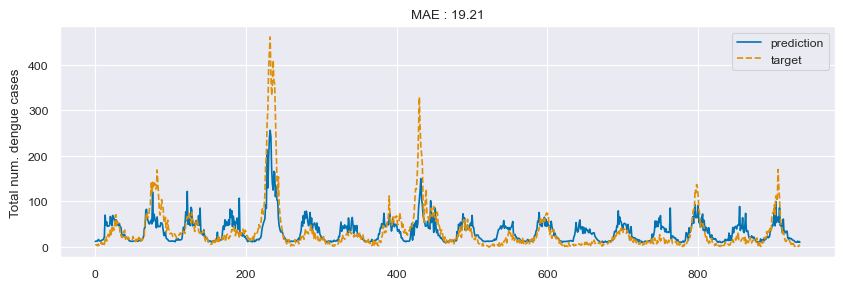

In [11]:
clf_sj = train_model(city="sj")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best score : 7.46


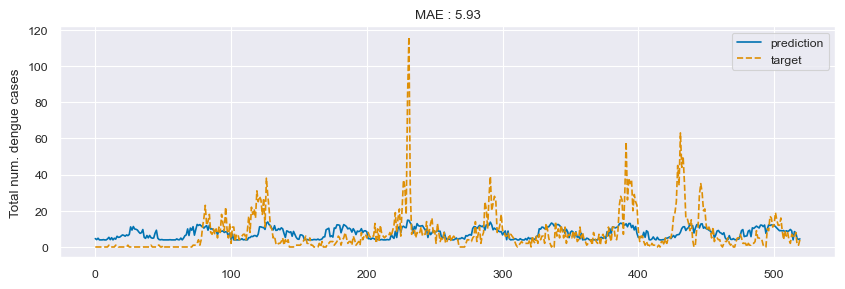

In [12]:
clf_iq = train_model(city="iq")

In [61]:
models = {
    "sj": clf_sj.best_estimator_,
    "iq": clf_iq.best_estimator_,
}

create_submission(name="testing-code", data_manager=data_manager, models=models)